In [1]:
import numpy
from time import time
from random import uniform
from math import sqrt

from multiprocessing import Pool
import ipyparallel


In [4]:
def throw_dart(_):
    x, y = uniform(0, 1), uniform(0, 1)
    if sqrt((0.5 - x)**2. + (0.5 - y)**2.) <= 0.5:
        return 1
    else: 
        return 0

    
nxvals = 50 #Number of points at which to sample the time
niter = 5 #Iterations to calculate error

#Number of darts
number_of_darts = 10**numpy.linspace(2, 7, nxvals)
number_of_darts = number_of_darts.astype('int32')

tserial = numpy.empty([nxvals, niter])
tmprocess = numpy.empty([nxvals, niter])
tipyparallel = numpy.empty([nxvals, niter])
piserial = numpy.empty([nxvals, niter])
pimprocess = numpy.empty([nxvals, niter])
piipyparallel = numpy.empty([nxvals, niter])

clients = ipyparallel.Client()
dview = clients.direct_view()
#Import files at all clusters
with dview.sync_imports(quiet=True):
    import numpy;
    from random import uniform;
    from math import sqrt;
clients.close()

for foo in range(nxvals):
    n_darts = number_of_darts[foo]
    for boo in range(niter):

        # For serial
        tstart = time()
        in_circle = numpy.array(list(map(throw_dart,range(n_darts)))).sum()
        tend = time()
        tserial[foo, boo] = tend - tstart
        piserial[foo, boo] = 4*in_circle/float(n_darts)

        # For multiprocessing
        tstart = time()
        pool = Pool(processes=4)
        in_circle = numpy.array(pool.map(throw_dart, range(n_darts))).sum()
        tend = time()
        pool.terminate()
        tmprocess[foo, boo] = tend - tstart
        pimprocess[foo, boo] = 4*in_circle/float(n_darts)

        # For Ipcluster
        tstart = time()
        clients = ipyparallel.Client()
        dview = clients.direct_view()
        in_circle = numpy.array(dview.map_sync(throw_dart, range(n_darts))).sum()
        tend = time()
        tipyparallel[foo, boo] = tend - tstart
        piipyparallel[foo, boo] = 4*in_circle/float(n_darts)
        clients.close()

#Import libraries to plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Plotting here
fig, ax = plt.subplots(figsize = (10, 8))
ax2 = ax.twinx()

ax = sns.tsplot(tserial.T, time=number_of_darts, color = "r", condition = "Serial")
ax = sns.tsplot(tmprocess.T, time=number_of_darts, color = "b", condition = "Multiprocessing -4")
ax = sns.tsplot(tipyparallel.T, time=number_of_darts, color = "g", condition = "Ipcluster -4")
ax.loglog()
ax.set_ylabel("Execution Time (in s), solid lines")
ax.set_xlabel("Number of Darts Thrown")

ax2 = sns.tsplot(number_of_darts/tserial.mean(axis = -1), time=number_of_darts, color = "r", ls = "--")
ax2 = sns.tsplot(number_of_darts/tmprocess.mean(axis = -1), time=number_of_darts, color = "b", ls = "--")
ax2 = sns.tsplot(number_of_darts/tipyparallel.mean(axis = -1), time=number_of_darts, color = "g", ls = "--")
ax2.grid(False)
ax2.loglog()
ax2.set_ylabel("Simulation Rate (darts/second), dashed lines")
ax2.set_ylim(10**1, 10**7)

plt.show()

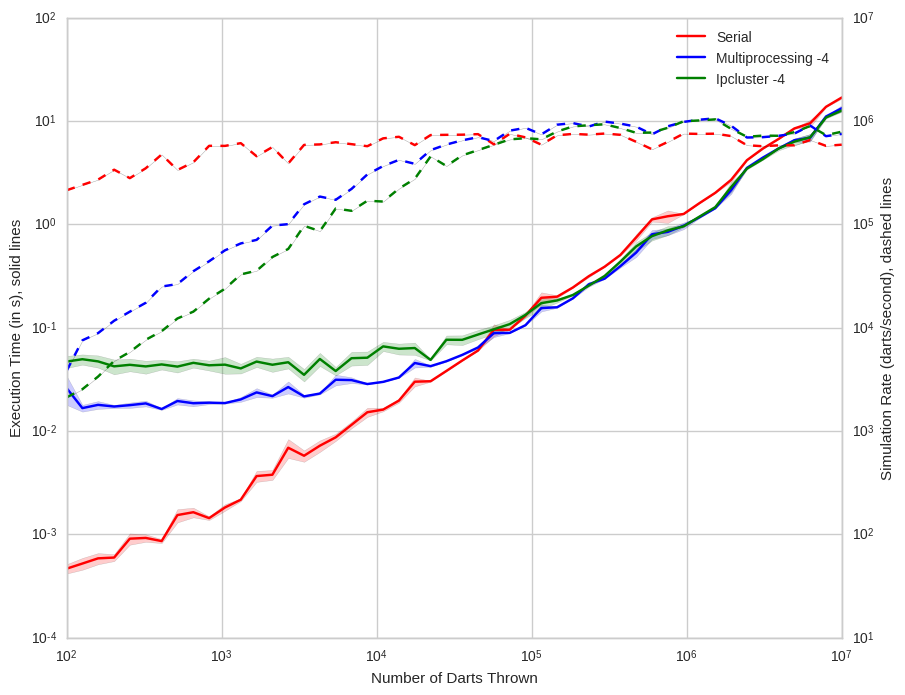

In [25]:
# fig, ax = plt.subplots(figsize = (10, 8))
# ax = sns.tsplot(tserial.T, time=number_of_darts, color = "r", condition = "Serial")
# ax = sns.tsplot(tmprocess.T, time=number_of_darts, color = "b", condition = "Multiprocessing -4")
# ax = sns.tsplot(tipyparallel.T, time=number_of_darts, color = "g", condition = "Ipcluster -4")
# ax.loglog()
# ax.set_ylabel("Execution Time (in s), solid lines")

# ax2 = ax.twinx()
# ax2 = sns.tsplot(number_of_darts/tserial.mean(axis = -1), time=number_of_darts, color = "r", ls = "--")
# ax2 = sns.tsplot(number_of_darts/tmprocess.mean(axis = -1), time=number_of_darts, color = "b", ls = "--")
# ax2 = sns.tsplot(number_of_darts/tipyparallel.mean(axis = -1), time=number_of_darts, color = "g", ls = "--")
# ax2.grid(False)
# ax2.loglog()
# ax2.set_ylabel("Simulation Rate (darts/second), dashed lines")
# ax2.set_ylim(10**1, 10**7)
# ax.set_xlabel("Number of Darts Thrown")

# plt.show()